In [1]:
import pickle
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt

import random
import itertools
import functools
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import gudhi.wasserstein as wasserstein
from torch_topological import nn as topnn

from advtopo import utils
from advtopo import models

In [2]:
device = torch.device("cpu")

### Get the data loaders and model

In [3]:
ds_train, ds_test = utils.get_torch_datasets()

/Users/Jens/Library/Caches/pypoetry/virtualenvs/advtopo-ZyCp4tIF-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
# ds_train[sample_id][0][Homology] is tensor (2, 500)
# First 0 is for input, 1 will give us label
# Notice that it is now transposed compared to before
print(ds_train[0][0][0].shape)
print(ds_train[0][0][1].shape)

torch.Size([2, 500])
torch.Size([2, 500])


In [5]:
dataloader_train = DataLoader(ds_train, batch_size=128, shuffle=True)
dataloader_test = DataLoader(ds_test, batch_size=128, shuffle=True)
model = models.Model_DeepSet().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, eps=1e-04)

### Check the model

In [6]:
model

Model_DeepSet(
  (h0): Sequential(
    (0): DeepSetLayer()
    (1): DeepSetLayer()
    (2): DeepSetTopK()
  )
  (h1): Sequential(
    (0): DeepSetLayer()
    (1): DeepSetLayer()
    (2): DeepSetTopK()
  )
  (merge): Sequential(
    (0): Linear(in_features=250, out_features=5, bias=True)
  )
)

In [7]:
for parameter in model.parameters():
    print(parameter.shape)

torch.Size([25, 2])
torch.Size([25])
torch.Size([25, 25])
torch.Size([25])
torch.Size([25, 25])
torch.Size([25, 2])
torch.Size([25])
torch.Size([25, 25])
torch.Size([25])
torch.Size([25, 25])
torch.Size([5, 250])
torch.Size([5])


In [8]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("Number of parameters: ", params)

Number of parameters:  3955


### Train

In [9]:
%%time
epochs = 100
for t in range(epochs):
  printit = True if t%10==0 else False
  if printit:
    print(f"Epoch {t+1}\n-------------------------------")
    
  models.train(dataloader_train, model, loss, optimizer, device, printit)

print("Done!")

Epoch 1
-------------------------------
loss: 1.607428  [    2/ 3500]
Epoch 11
-------------------------------
loss: 0.387415  [    2/ 3500]
Epoch 21
-------------------------------
loss: 0.414274  [    2/ 3500]
Epoch 31
-------------------------------
loss: 0.377037  [    2/ 3500]
Epoch 41
-------------------------------
loss: 0.265829  [    2/ 3500]
Epoch 51
-------------------------------
loss: 0.150706  [    2/ 3500]
Epoch 61
-------------------------------
loss: 0.334586  [    2/ 3500]
Epoch 71
-------------------------------
loss: 0.212362  [    2/ 3500]
Epoch 81
-------------------------------
loss: 0.273332  [    2/ 3500]
Epoch 91
-------------------------------
loss: 0.261454  [    2/ 3500]
Done!
CPU times: user 2min 12s, sys: 49.6 s, total: 3min 1s
Wall time: 1min 13s


In [14]:
test_loss, correct, preds, ground_truth = models.test(dataloader_test, model, loss, device)

In [15]:
correct

0.8753333333333333

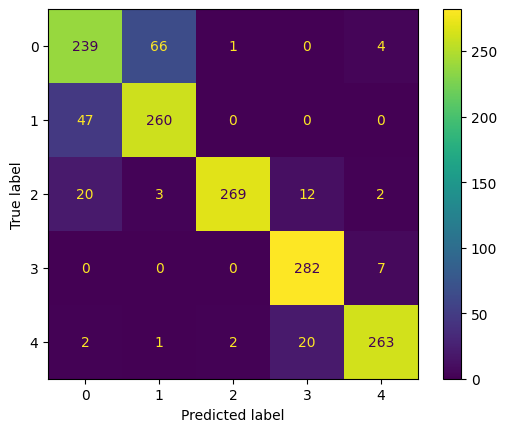

In [16]:
preds = torch.concat(preds)
ground_truth = torch.concat(ground_truth)

cm = confusion_matrix(ground_truth.cpu().numpy(), preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [35]:
torch.save(model.state_dict(), "./model_deepset")

In [ ]:
model